# MNISTでcGANを試す

## moduleのimport

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

## データの前処理に使うtransform

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     ])

## torchvisionからデータをダウンロードし、transformで前処理

In [3]:
#データをtorchvisionでダウンロード
dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

## Dataloaderの定義

In [4]:
import numpy as np
batch_size = 128

#データローダー
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=6)

## ネットワーク：Generatorの定義

In [5]:
class Generator(nn.Module):
    def __init__(self, z_dim, num_class):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(z_dim, 200)
        self.bn1 = nn.BatchNorm1d(200)
        self.fc2 = nn.Linear(num_class, 1000)
        self.bn2 = nn.BatchNorm1d(1000)
        
        self.fc3 = nn.Linear(1200, 128 * 7 * 7)
        
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128,64, kernel_size=4, stride=2, padding=1), #チャネル数を128⇒64に変える。
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64,1, kernel_size=4, stride=2, padding=1), #チャネル数を28×28に変更
            nn.Sigmoid(),
        )
        
        self.init_weights()
        
    def init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.ConvTranspose2d):
                module.weight.data.normal_(0, 0.02)
                module.bias.data.zero_()
            elif isinstance(module, nn.Linear):
                module.weight.data.normal_(0, 0.02)
                module.bias.data.zero_()
        
    def forward(self, noise, labels):
        y_1 = self.fc1(noise)
        y_1 = F.relu(y_1)
        y_1 = self.bn1(y_1)
        
        y_2 = self.fc2(labels)
        y_2 = F.relu(y_2)
        y_2 = self.bn2(y_2)
        
        x = torch.cat([y_1, y_2], 1)
        x = self.fc3(x)
        x = x.view(-1, 128, 7, 7)
        x = self.deconv(x)
        return x
        

## ネットワーク：Discriminatorの定義

In [6]:
class Discriminator(nn.Module):
    def __init__(self, num_class):
        super(Discriminator, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1), #入力は1チャネル(白黒だから), フィルターの数64, フィルターのサイズ4*4
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
            
        self.fc1 = nn.Linear(num_class, 1000)
        self.bn1 = nn.BatchNorm1d(1000)
            
        self.fc = nn.Sequential(
            nn.Linear(128 * 7 * 7 + 1000, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )
            
    def forward(self, img, labels):
        y_1 = self.conv(img)
        y_1 = y_1.view(-1, 128 * 7 * 7)
        
        y_2 = self.fc1(labels)
        y_2 = F.relu(y_2)
        y_2 = self.bn1(y_2)
        
        x = torch.cat([y_1, y_2], 1)
        x = self.fc(x)
        return x

## 1エポックごとに計算する関数を定義

In [7]:
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_func(D_model, G_model, batch_size, z_dim, num_class,criterion, D_optimizer, G_optimizer, D_scheduler, G_scheduler, data_loader, device):
    #訓練モード
    D_model.train()
    G_model.train()
    
    #本物のラベルは1
    y_real = torch.ones((batch_size, 1)).to(device)

    #偽物のラベルは0
    y_fake = torch.zeros((batch_size, 1)).to(device)
    
    #lossの初期化
    D_running_loss = 0
    G_running_loss = 0
    
    #バッチごとの計算
    for batch_idx, (data, labels) in enumerate(data_loader):
        #バッチサイズに満たない場合は無視
        if data.size()[0] != batch_size:
            break
        
        #ノイズ作成
        z = torch.rand((batch_size, z_dim)) #[0,1)の一様分布に従った乱数を生成
        #Generatorに入れるラベルを生成
        z_labels = torch.zeros(batch_size, num_class)
        randint = torch.randint(10,(batch_size,))
        for i in range(batch_size):
            z_labels[i, randint[i]] = 1
        z_label = z_labels.clone().detach().requires_grad_(True)
    
        
        #本物データのラベルをone_hot vectorに変換
        label_matrix = torch.zeros(batch_size, num_class)
        for i in range(len(labels)):
            label_matrix[i, labels[i]] = 1
        labels = label_matrix.clone().detach().requires_grad_(True)
            
        real_img, z, label, z_label = data.to(device), z.to(device), labels.to(device), z_label.to(device)
        
        #Discriminatorの更新
        D_optimizer.zero_grad()
        
        #Discriminatorに本物画像を入れて順伝播⇒Loss計算
        D_real = D_model(real_img, label)
        D_real_loss = criterion(D_real, y_real)
        
        #DiscriminatorにGeneratorにノイズを入れて作った画像を入れて順伝播⇒Loss計算
        fake_img = G_model(z, z_label)
        D_fake = D_model(fake_img.detach(), z_label) #fake_imagesで計算したLossをGeneratorに逆伝播させないように止める
        D_fake_loss = criterion(D_fake, y_fake)
        
        #2つのLossの和を最小化
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()
        D_running_loss += D_loss.item()
        
        #Generatorの更新
        G_optimizer.zero_grad()
        
        #Generatorにノイズを入れて作った画像をDiscriminatorに入れて順伝播⇒見破られた分がLossになる
        fake_img = G_model(z, z_label)
        D_fake = D_model(fake_img, z_label)
        G_loss = criterion(D_fake, y_real)
        G_loss.backward()
        G_optimizer.step()
        G_running_loss += G_loss.item()
        
        #schedulerの更新
        if D_scheduler != 'None':
            D_scheduler.step()
        if G_scheduler != 'None':
            G_scheduler.step()
        
    D_running_loss /= len(data_loader)
    G_running_loss /= len(data_loader)
    
    return D_running_loss, G_running_loss

## Generatorが作った画像を表示する関数

In [8]:
import os
from IPython.display import Image
from torchvision.utils import save_image
%matplotlib inline

def Generate_img(epoch, G_model, device, z_dim, noise, var_mode, labels, log_dir = 'logs_cGAN'):
    G_model.eval()
    
    with torch.no_grad():
        if var_mode == True:
            #生成に必要な乱数
            noise = torch.rand((80, z_dim)).to(device)
        else:
            noise = noise

        #Generatorでサンプル生成
        samples = G_model(noise, labels).data.cpu()
        save_image(samples, os.path.join(log_dir, 'epoch_%05d.png' % (epoch)))
        img = Image('logs_cGAN/epoch_%05d.png' % (epoch))
        display(img)

## モデルをエポックごとに計算し、結果を表示

In [9]:
import time
import adabound
import random
import numpy as np
import torch.optim as optim

#再現性確保のためseed値固定
SEED = 1111
random.seed(SEED)
np.random.seed(SEED) 
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

#optimizerを決める関数
def return_optim(optim, model):
    if optim == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
    elif optim == 'Adadelta':
        optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
    elif optim == 'Adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)
    elif optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0002, betas=(0.5, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    elif optim == 'Adabound':
        optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=0.1)
        
    return optimizer

#schedulerを決める関数
def return_scheduler(scheduler, model):
    if scheduler == 'None':
        shceduler = 'None'
    elif scheduler == 'StepLR':
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, int(num_epochs/2), gamma=0.5)
    elif scheduler == 'MultiStepLR':
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(num_epochs/4),int(num_epochs*2/4),int(num_epochs*3/4)], gamma=0.1, last_epoch=-1)
    elif scheduler == 'ExponentialLR':
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma, last_epoch=-1)
    elif scheduler == 'CosineAnnelingLR':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(num_epochs/4), eta_min=0, last_epoch=-1)
    elif scheduler == 'ReduceLROnPlateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=False, \
                                                               threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
    elif scheduler == 'CyclicLR':
        scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=3, step_size_up=2000, step_size_down=None, \
                                                      mode='triangular', gamma=1.0, scale_fn=None, scale_mode='cycle', cycle_momentum=True,\
                                                      base_momentum=0.8, max_momentum=0.9, last_epoch=-1)
    
    return scheduler
    

def model_run(num_epochs, batch_size = batch_size, D_optim = 'SGD', G_optim = 'SGD', D_scheduler = 'None', G_scheduler = 'None', dataloader = dataloader, device = device):
    
    #ハイパーパラメータ
    z_dim = 62
    var_mode = False #表示結果を見るときに毎回異なる乱数を使うかどうか
    #生成に必要な乱数
    noise = torch.rand((80, z_dim)).to(device)
    
    #クラス数
    num_class = 10
    
    #Generatorを試すときに使うラベルを作る
    sample_num = 80 #画像を何個生成するか
    sample_num = 80 #画像を何個生成するか
    labels = torch.zeros(sample_num, num_class)
    for k in range(num_class):
        for i in range(int(sample_num / num_class)):
            labels[i + (k * int(sample_num / num_class)) , k] = 1
    label = labels.clone().detach().requires_grad_(True).to(device)
    
    #モデル定義
    #min_valid_loss = float('inf')
    D_model = Discriminator(num_class).to(device)
    G_model = Generator(z_dim, num_class).to(device)
    
    #lossの定義(引数はtrain_funcの中で指定)
    criterion = nn.BCELoss().to(device)
    
    #optimizerの定義
    D_optimizer = return_optim(D_optim, D_model)
    G_optimizer = return_optim(G_optim, G_model)
    
    #scheduler（学習率の調整法）の定義
    D_scheduler = return_scheduler(D_scheduler, D_optim)
    G_scheduler = return_scheduler(G_scheduler, G_optim)
    
    D_loss_list = []
    G_loss_list = []
    
    all_time = time.time()
    for epoch in range(num_epochs):
        start_time = time.time()
        
        D_loss, G_loss = train_func(D_model, G_model, batch_size, z_dim, num_class,criterion, D_optimizer, G_optimizer, D_scheduler, G_scheduler, dataloader, device)
        
        D_loss_list.append(D_loss)
        G_loss_list.append(G_loss)
        
        secs = int(time.time() - start_time)
        mins = secs / 60
        secs = secs % 60
        
        #エポックごとに結果を表示
        print('Epoch: %d' %(epoch + 1), " | 所要時間 %d 分 %d 秒" %(mins, secs))
        print(f'\tLoss: {D_loss:.4f}(Discriminator)')
        print(f'\tLoss: {G_loss:.4f}(Generator)')
        
        if (epoch + 1) % 1 == 0:
            Generate_img(epoch, G_model, device, z_dim, noise, var_mode, label)
            
    return D_loss_list, G_loss_list

Epoch: 1  | 所要時間 0 分 10 秒
	Loss: 0.7102(Discriminator)
	Loss: 1.6245(Generator)


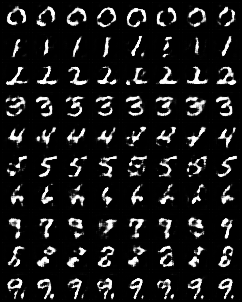

Epoch: 2  | 所要時間 0 分 10 秒
	Loss: 0.7666(Discriminator)
	Loss: 1.6177(Generator)


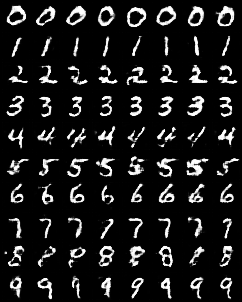

Epoch: 3  | 所要時間 0 分 10 秒
	Loss: 0.7959(Discriminator)
	Loss: 1.5716(Generator)


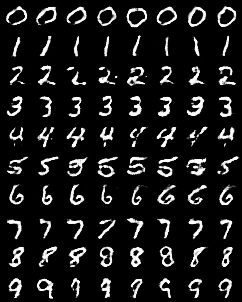

Epoch: 4  | 所要時間 0 分 10 秒
	Loss: 0.8006(Discriminator)
	Loss: 1.5655(Generator)


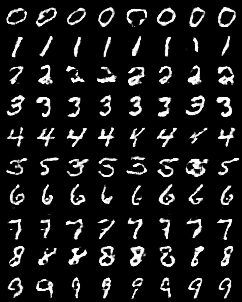

Epoch: 5  | 所要時間 0 分 10 秒
	Loss: 0.7802(Discriminator)
	Loss: 1.6150(Generator)


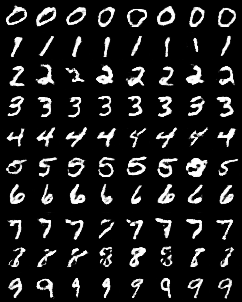

Epoch: 6  | 所要時間 0 分 11 秒
	Loss: 0.7322(Discriminator)
	Loss: 1.6899(Generator)


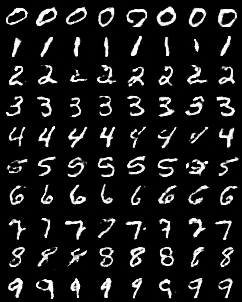

Epoch: 7  | 所要時間 0 分 10 秒
	Loss: 0.6862(Discriminator)
	Loss: 1.7848(Generator)


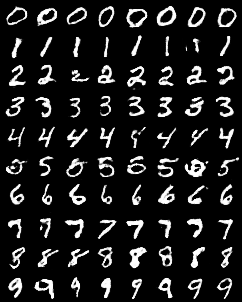

Epoch: 8  | 所要時間 0 分 10 秒
	Loss: 0.6504(Discriminator)
	Loss: 1.8806(Generator)


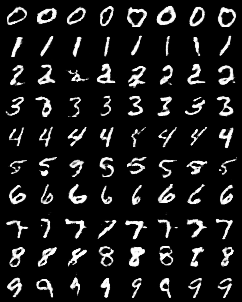

Epoch: 9  | 所要時間 0 分 10 秒
	Loss: 0.6180(Discriminator)
	Loss: 1.9614(Generator)


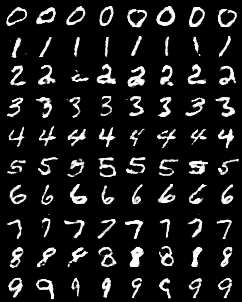

Epoch: 10  | 所要時間 0 分 11 秒
	Loss: 0.5890(Discriminator)
	Loss: 2.0298(Generator)


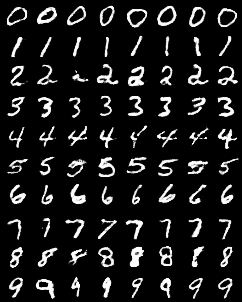

Epoch: 11  | 所要時間 0 分 10 秒
	Loss: 0.5497(Discriminator)
	Loss: 2.1365(Generator)


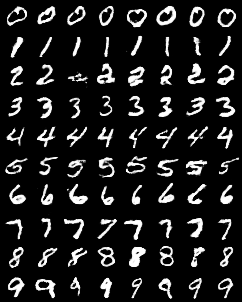

Epoch: 12  | 所要時間 0 分 11 秒
	Loss: 0.5308(Discriminator)
	Loss: 2.2127(Generator)


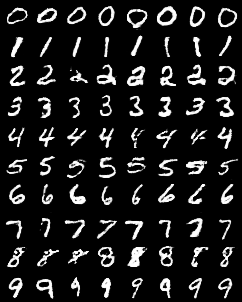

Epoch: 13  | 所要時間 0 分 10 秒
	Loss: 0.5076(Discriminator)
	Loss: 2.2659(Generator)


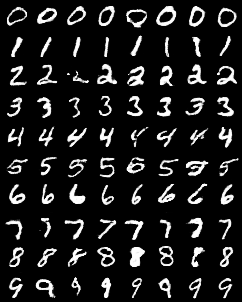

Epoch: 14  | 所要時間 0 分 11 秒
	Loss: 0.4865(Discriminator)
	Loss: 2.3694(Generator)


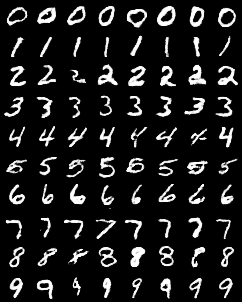

Epoch: 15  | 所要時間 0 分 10 秒
	Loss: 0.4513(Discriminator)
	Loss: 2.4485(Generator)


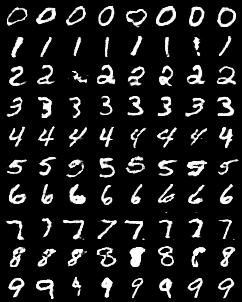

Epoch: 16  | 所要時間 0 分 10 秒
	Loss: 0.4470(Discriminator)
	Loss: 2.5072(Generator)


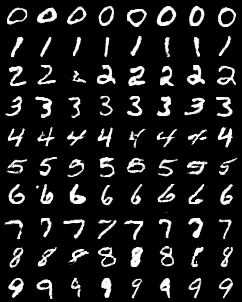

Epoch: 17  | 所要時間 0 分 10 秒
	Loss: 0.4153(Discriminator)
	Loss: 2.5797(Generator)


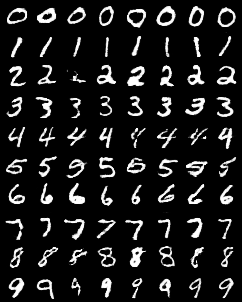

Epoch: 18  | 所要時間 0 分 10 秒
	Loss: 0.4167(Discriminator)
	Loss: 2.6657(Generator)


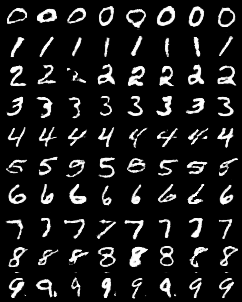

Epoch: 19  | 所要時間 0 分 11 秒
	Loss: 0.3891(Discriminator)
	Loss: 2.7394(Generator)


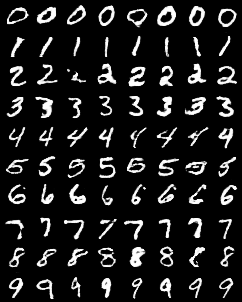

Epoch: 20  | 所要時間 0 分 10 秒
	Loss: 0.3746(Discriminator)
	Loss: 2.8228(Generator)


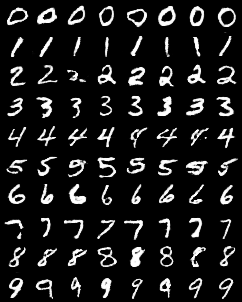

Epoch: 21  | 所要時間 0 分 10 秒
	Loss: 0.3612(Discriminator)
	Loss: 2.8860(Generator)


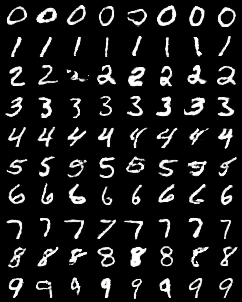

Epoch: 22  | 所要時間 0 分 11 秒
	Loss: 0.3420(Discriminator)
	Loss: 2.9413(Generator)


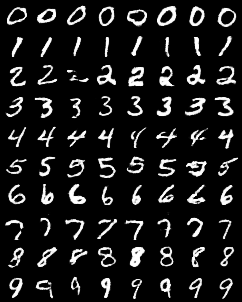

Epoch: 23  | 所要時間 0 分 11 秒
	Loss: 0.3370(Discriminator)
	Loss: 2.9976(Generator)


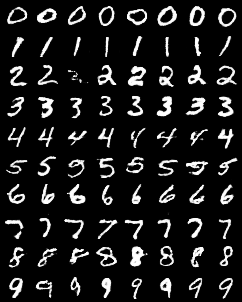

Epoch: 24  | 所要時間 0 分 11 秒
	Loss: 0.3351(Discriminator)
	Loss: 3.0425(Generator)


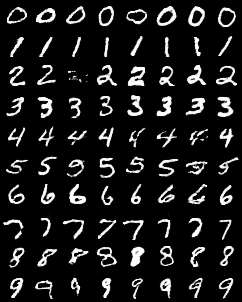

Epoch: 25  | 所要時間 0 分 10 秒
	Loss: 0.3294(Discriminator)
	Loss: 3.0982(Generator)


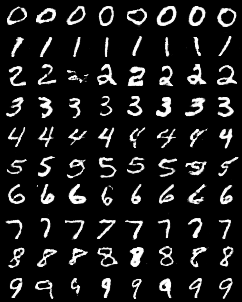

Epoch: 26  | 所要時間 0 分 10 秒
	Loss: 0.3086(Discriminator)
	Loss: 3.1738(Generator)


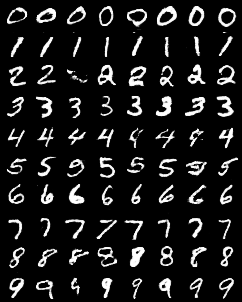

Epoch: 27  | 所要時間 0 分 10 秒
	Loss: 0.3063(Discriminator)
	Loss: 3.2010(Generator)


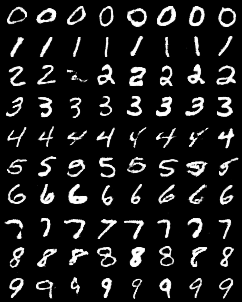

Epoch: 28  | 所要時間 0 分 11 秒
	Loss: 0.2849(Discriminator)
	Loss: 3.2849(Generator)


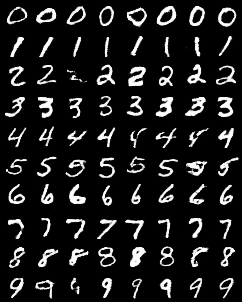

Epoch: 29  | 所要時間 0 分 10 秒
	Loss: 0.2950(Discriminator)
	Loss: 3.3318(Generator)


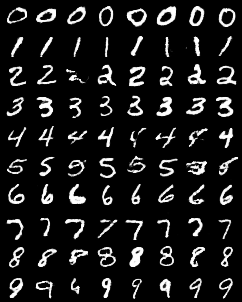

Epoch: 30  | 所要時間 0 分 10 秒
	Loss: 0.2770(Discriminator)
	Loss: 3.3773(Generator)


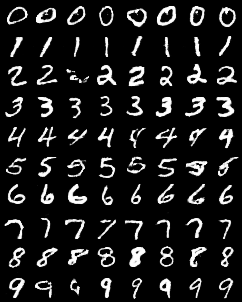

Epoch: 31  | 所要時間 0 分 10 秒
	Loss: 0.2407(Discriminator)
	Loss: 3.4744(Generator)


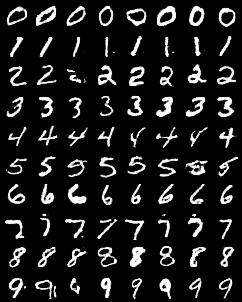

Epoch: 32  | 所要時間 0 分 10 秒
	Loss: 0.2604(Discriminator)
	Loss: 3.5476(Generator)


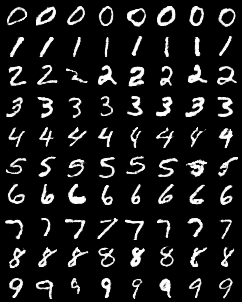

Epoch: 33  | 所要時間 0 分 10 秒
	Loss: 0.2531(Discriminator)
	Loss: 3.5789(Generator)


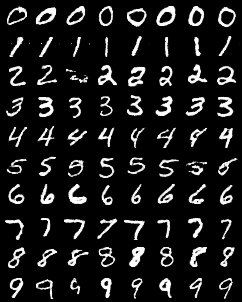

Epoch: 34  | 所要時間 0 分 10 秒
	Loss: 0.2465(Discriminator)
	Loss: 3.6313(Generator)


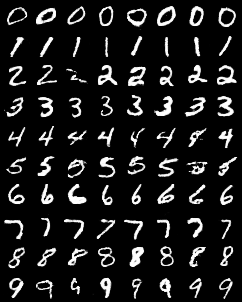

Epoch: 35  | 所要時間 0 分 10 秒
	Loss: 0.2717(Discriminator)
	Loss: 3.6739(Generator)


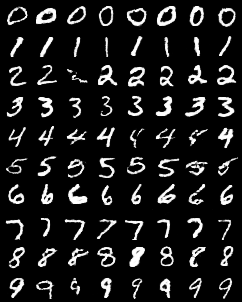

Epoch: 36  | 所要時間 0 分 10 秒
	Loss: 0.2317(Discriminator)
	Loss: 3.6130(Generator)


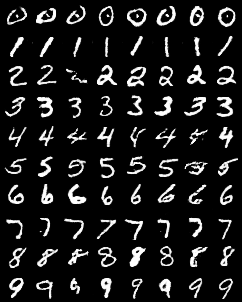

Epoch: 37  | 所要時間 0 分 10 秒
	Loss: 0.2252(Discriminator)
	Loss: 3.7380(Generator)


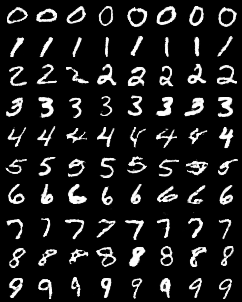

Epoch: 38  | 所要時間 0 分 10 秒
	Loss: 0.2294(Discriminator)
	Loss: 3.7572(Generator)


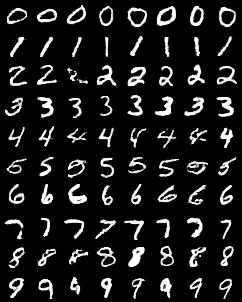

Epoch: 39  | 所要時間 0 分 10 秒
	Loss: 0.2127(Discriminator)
	Loss: 3.8399(Generator)


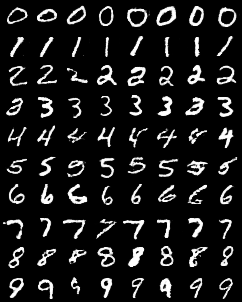

Epoch: 40  | 所要時間 0 分 10 秒
	Loss: 0.2423(Discriminator)
	Loss: 3.8595(Generator)


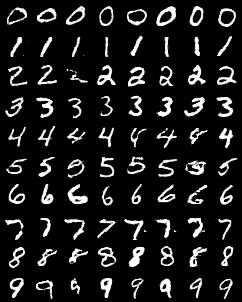

Epoch: 41  | 所要時間 0 分 10 秒
	Loss: 0.2054(Discriminator)
	Loss: 3.8382(Generator)


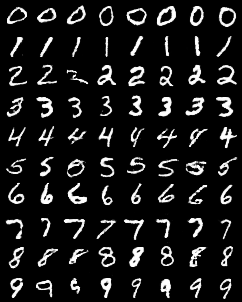

Epoch: 42  | 所要時間 0 分 10 秒
	Loss: 0.1814(Discriminator)
	Loss: 3.9700(Generator)


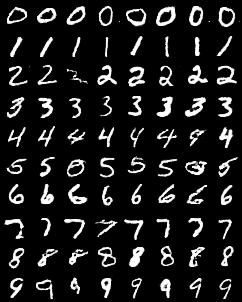

Epoch: 43  | 所要時間 0 分 11 秒
	Loss: 0.2272(Discriminator)
	Loss: 3.9929(Generator)


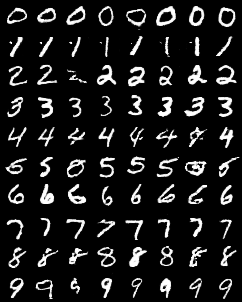

Epoch: 44  | 所要時間 0 分 10 秒
	Loss: 0.1742(Discriminator)
	Loss: 4.0867(Generator)


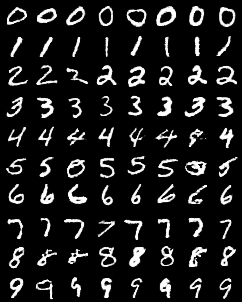

Epoch: 45  | 所要時間 0 分 10 秒
	Loss: 0.2121(Discriminator)
	Loss: 4.0858(Generator)


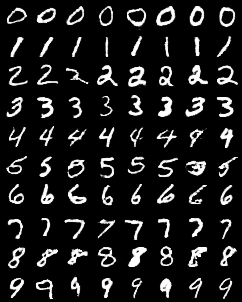

Epoch: 46  | 所要時間 0 分 10 秒
	Loss: 0.1598(Discriminator)
	Loss: 4.1213(Generator)


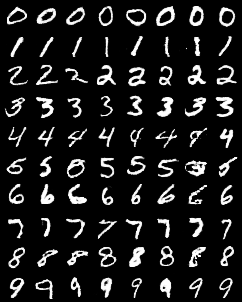

Epoch: 47  | 所要時間 0 分 10 秒
	Loss: 0.2398(Discriminator)
	Loss: 4.1616(Generator)


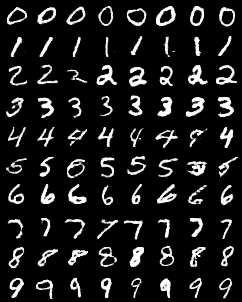

Epoch: 48  | 所要時間 0 分 10 秒
	Loss: 0.1287(Discriminator)
	Loss: 4.1989(Generator)


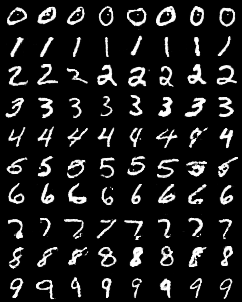

Epoch: 49  | 所要時間 0 分 10 秒
	Loss: 0.2308(Discriminator)
	Loss: 4.2275(Generator)


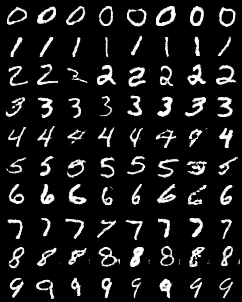

Epoch: 50  | 所要時間 0 分 10 秒
	Loss: 0.1739(Discriminator)
	Loss: 4.2048(Generator)


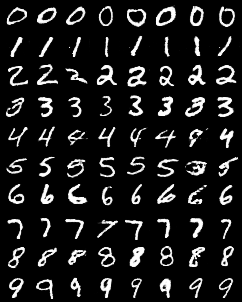

Epoch: 51  | 所要時間 0 分 10 秒
	Loss: 0.1916(Discriminator)
	Loss: 4.2271(Generator)


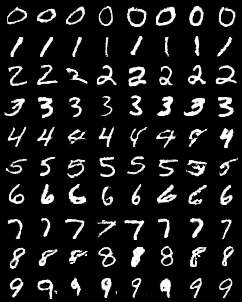

Epoch: 52  | 所要時間 0 分 10 秒
	Loss: 0.1285(Discriminator)
	Loss: 4.3334(Generator)


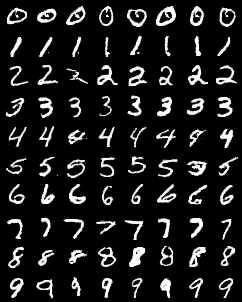

Epoch: 53  | 所要時間 0 分 10 秒
	Loss: 0.2025(Discriminator)
	Loss: 4.3642(Generator)


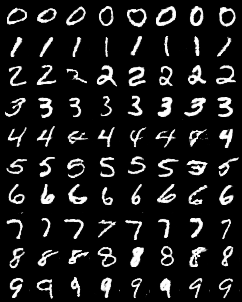

Epoch: 54  | 所要時間 0 分 10 秒
	Loss: 0.1787(Discriminator)
	Loss: 4.3555(Generator)


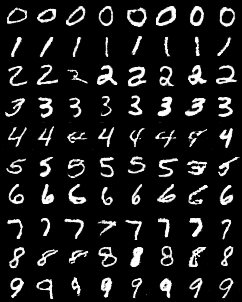

Epoch: 55  | 所要時間 0 分 10 秒
	Loss: 0.1443(Discriminator)
	Loss: 4.3597(Generator)


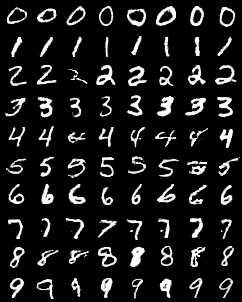

Epoch: 56  | 所要時間 0 分 10 秒
	Loss: 0.1838(Discriminator)
	Loss: 4.4263(Generator)


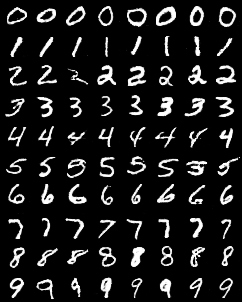

Epoch: 57  | 所要時間 0 分 11 秒
	Loss: 0.1702(Discriminator)
	Loss: 4.4326(Generator)


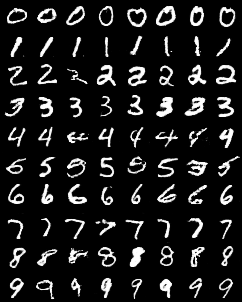

Epoch: 58  | 所要時間 0 分 11 秒
	Loss: 0.1203(Discriminator)
	Loss: 4.5412(Generator)


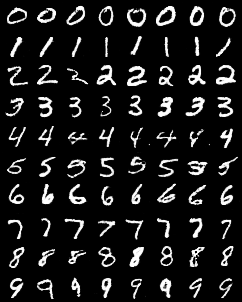

Epoch: 59  | 所要時間 0 分 10 秒
	Loss: 0.1863(Discriminator)
	Loss: 4.5205(Generator)


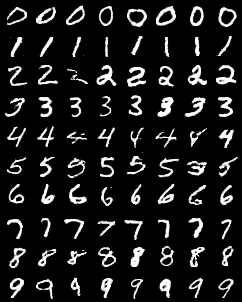

Epoch: 60  | 所要時間 0 分 10 秒
	Loss: 0.1630(Discriminator)
	Loss: 4.5705(Generator)


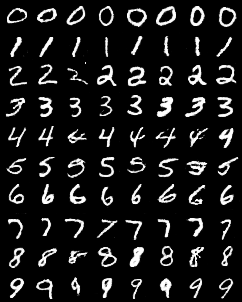

Epoch: 61  | 所要時間 0 分 11 秒
	Loss: 0.1355(Discriminator)
	Loss: 4.5725(Generator)


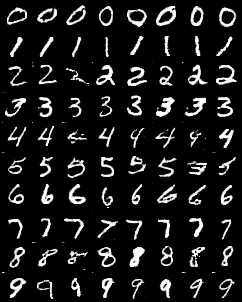

Epoch: 62  | 所要時間 0 分 11 秒
	Loss: 0.1375(Discriminator)
	Loss: 4.6808(Generator)


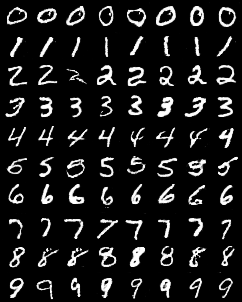

Epoch: 63  | 所要時間 0 分 10 秒
	Loss: 0.1651(Discriminator)
	Loss: 4.5465(Generator)


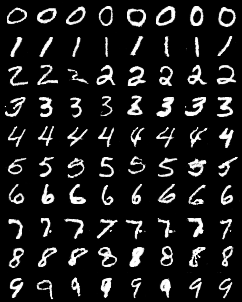

Epoch: 64  | 所要時間 0 分 10 秒
	Loss: 0.1367(Discriminator)
	Loss: 4.7684(Generator)


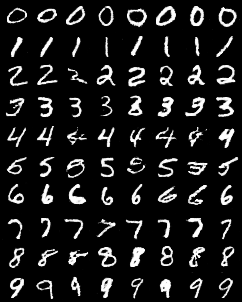

Epoch: 65  | 所要時間 0 分 10 秒
	Loss: 0.1744(Discriminator)
	Loss: 4.6291(Generator)


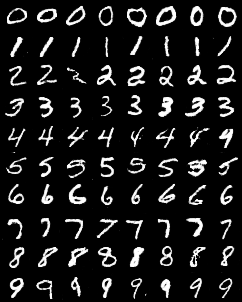

Epoch: 66  | 所要時間 0 分 10 秒
	Loss: 0.0914(Discriminator)
	Loss: 4.7546(Generator)


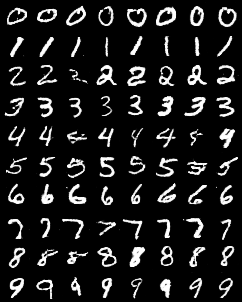

Epoch: 67  | 所要時間 0 分 10 秒
	Loss: 0.1798(Discriminator)
	Loss: 4.7169(Generator)


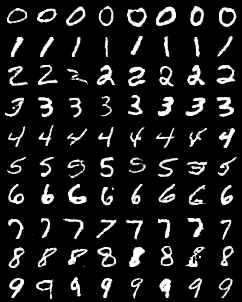

Epoch: 68  | 所要時間 0 分 10 秒
	Loss: 0.0863(Discriminator)
	Loss: 4.8432(Generator)


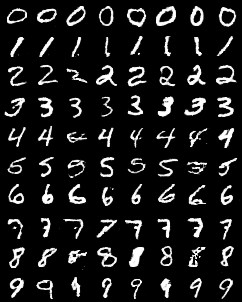

Epoch: 69  | 所要時間 0 分 10 秒
	Loss: 0.1719(Discriminator)
	Loss: 4.8815(Generator)


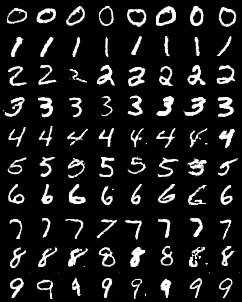

Epoch: 70  | 所要時間 0 分 10 秒
	Loss: 0.1530(Discriminator)
	Loss: 4.7830(Generator)


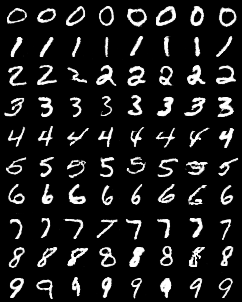

Epoch: 71  | 所要時間 0 分 10 秒
	Loss: 0.1334(Discriminator)
	Loss: 4.9048(Generator)


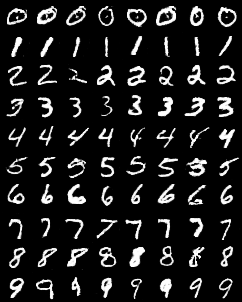

Epoch: 72  | 所要時間 0 分 10 秒
	Loss: 0.1400(Discriminator)
	Loss: 4.7593(Generator)


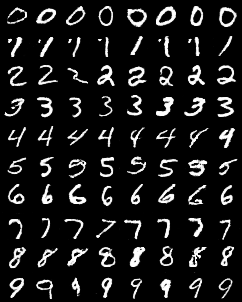

Epoch: 73  | 所要時間 0 分 11 秒
	Loss: 0.1154(Discriminator)
	Loss: 4.9785(Generator)


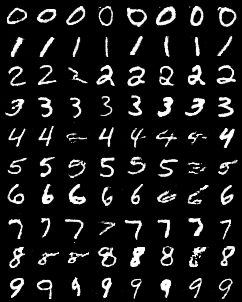

Epoch: 74  | 所要時間 0 分 11 秒
	Loss: 0.1143(Discriminator)
	Loss: 4.9453(Generator)


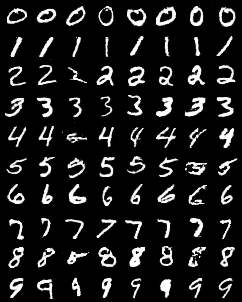

Epoch: 75  | 所要時間 0 分 10 秒
	Loss: 0.1605(Discriminator)
	Loss: 4.9728(Generator)


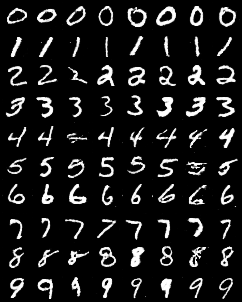

Epoch: 76  | 所要時間 0 分 10 秒
	Loss: 0.1234(Discriminator)
	Loss: 4.9789(Generator)


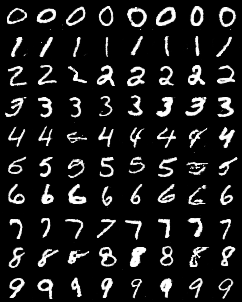

Epoch: 77  | 所要時間 0 分 11 秒
	Loss: 0.1305(Discriminator)
	Loss: 4.8748(Generator)


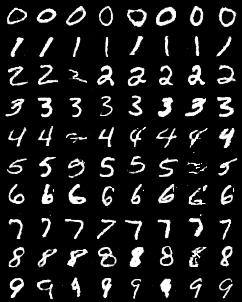

Epoch: 78  | 所要時間 0 分 10 秒
	Loss: 0.1107(Discriminator)
	Loss: 5.0942(Generator)


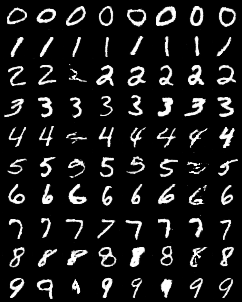

Epoch: 79  | 所要時間 0 分 10 秒
	Loss: 0.1577(Discriminator)
	Loss: 4.8365(Generator)


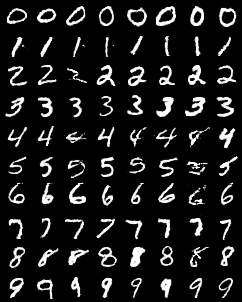

Epoch: 80  | 所要時間 0 分 11 秒
	Loss: 0.0645(Discriminator)
	Loss: 5.0226(Generator)


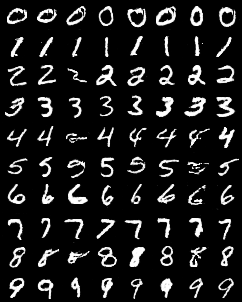

Epoch: 81  | 所要時間 0 分 10 秒
	Loss: 0.2143(Discriminator)
	Loss: 5.0549(Generator)


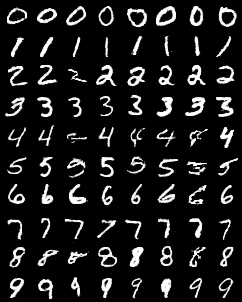

Epoch: 82  | 所要時間 0 分 10 秒
	Loss: 0.0623(Discriminator)
	Loss: 5.0161(Generator)


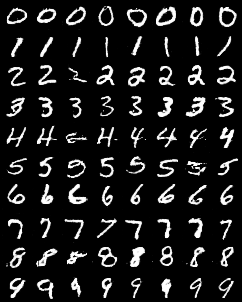

Epoch: 83  | 所要時間 0 分 10 秒
	Loss: 0.1609(Discriminator)
	Loss: 5.2098(Generator)


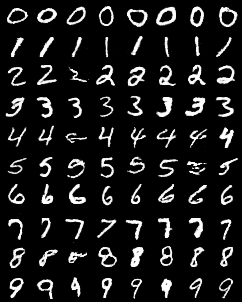

Epoch: 84  | 所要時間 0 分 10 秒
	Loss: 0.1228(Discriminator)
	Loss: 4.9312(Generator)


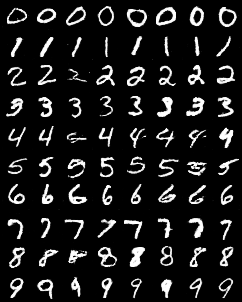

Epoch: 85  | 所要時間 0 分 10 秒
	Loss: 0.0726(Discriminator)
	Loss: 5.1879(Generator)


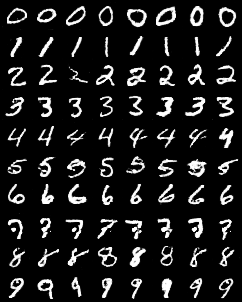

Epoch: 86  | 所要時間 0 分 11 秒
	Loss: 0.1692(Discriminator)
	Loss: 5.1738(Generator)


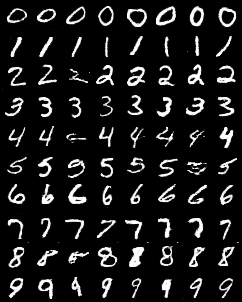

Epoch: 87  | 所要時間 0 分 10 秒
	Loss: 0.1096(Discriminator)
	Loss: 5.0651(Generator)


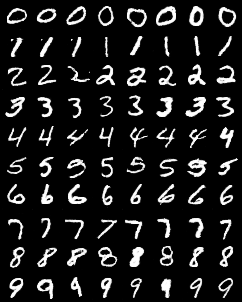

Epoch: 88  | 所要時間 0 分 10 秒
	Loss: 0.0987(Discriminator)
	Loss: 5.0831(Generator)


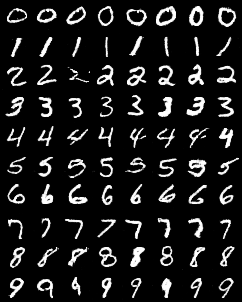

Epoch: 89  | 所要時間 0 分 10 秒
	Loss: 0.1178(Discriminator)
	Loss: 5.2573(Generator)


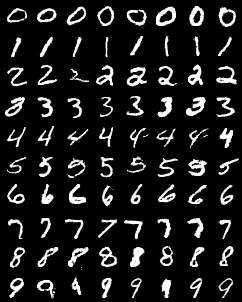

Epoch: 90  | 所要時間 0 分 11 秒
	Loss: 0.0655(Discriminator)
	Loss: 5.2688(Generator)


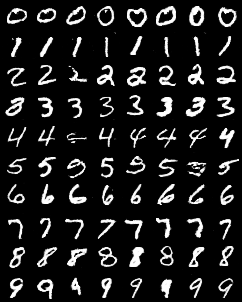

Epoch: 91  | 所要時間 0 分 10 秒
	Loss: 0.1735(Discriminator)
	Loss: 5.0556(Generator)


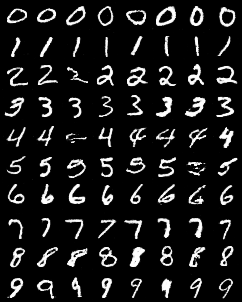

Epoch: 92  | 所要時間 0 分 10 秒
	Loss: 0.0976(Discriminator)
	Loss: 5.1566(Generator)


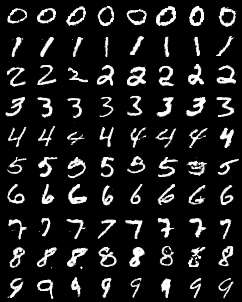

Epoch: 93  | 所要時間 0 分 10 秒
	Loss: 0.1232(Discriminator)
	Loss: 5.4169(Generator)


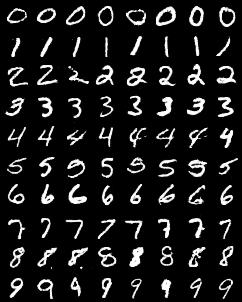

Epoch: 94  | 所要時間 0 分 10 秒
	Loss: 0.1487(Discriminator)
	Loss: 5.1007(Generator)


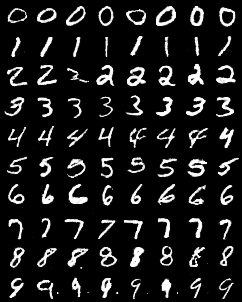

Epoch: 95  | 所要時間 0 分 10 秒
	Loss: 0.0758(Discriminator)
	Loss: 5.2840(Generator)


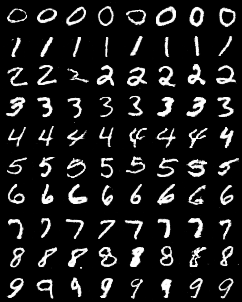

Epoch: 96  | 所要時間 0 分 10 秒
	Loss: 0.1207(Discriminator)
	Loss: 5.2561(Generator)


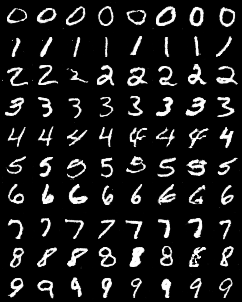

Epoch: 97  | 所要時間 0 分 10 秒
	Loss: 0.0485(Discriminator)
	Loss: 5.4266(Generator)


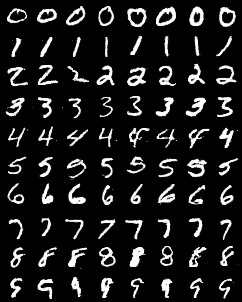

Epoch: 98  | 所要時間 0 分 10 秒
	Loss: 0.1697(Discriminator)
	Loss: 5.3185(Generator)


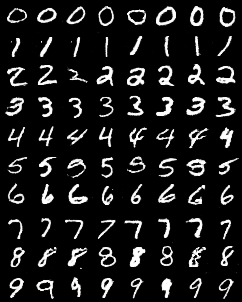

Epoch: 99  | 所要時間 0 分 11 秒
	Loss: 0.0971(Discriminator)
	Loss: 5.2849(Generator)


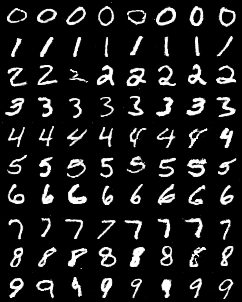

Epoch: 100  | 所要時間 0 分 10 秒
	Loss: 0.1146(Discriminator)
	Loss: 5.3300(Generator)


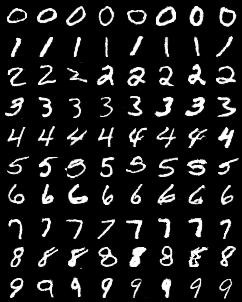

In [10]:
D_loss_list, G_loss_list = model_run(num_epochs = 100, batch_size = batch_size, D_optim = 'Adam', G_optim = 'Adam')

## DiscriminatorとGeneratorのlossを表示

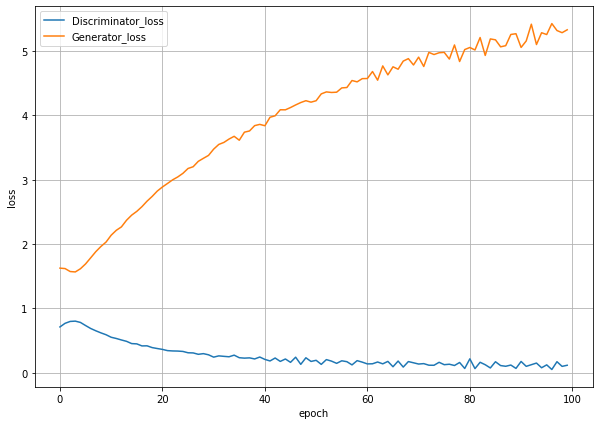

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10,7))

loss = fig.add_subplot(1,1,1)

loss.plot(range(len(D_loss_list)),D_loss_list,label='Discriminator_loss')
loss.plot(range(len(G_loss_list)),G_loss_list,label='Generator_loss')

loss.set_xlabel('epoch')
loss.set_ylabel('loss')

loss.legend()
loss.grid()

fig.show()


## アニメーションのgifを作る

In [12]:
import glob
from PIL import Image

files = glob.glob('./logs_cGAN/*.png')
files.sort()

images = list(map(lambda file: Image.open(file), files))

images[0].save('cGAN.gif', save_all=True, append_images=images[1:], duration=100, loop=0)